In [1]:
from IPython.display import HTML
from IPython.display import Image
import webbrowser 

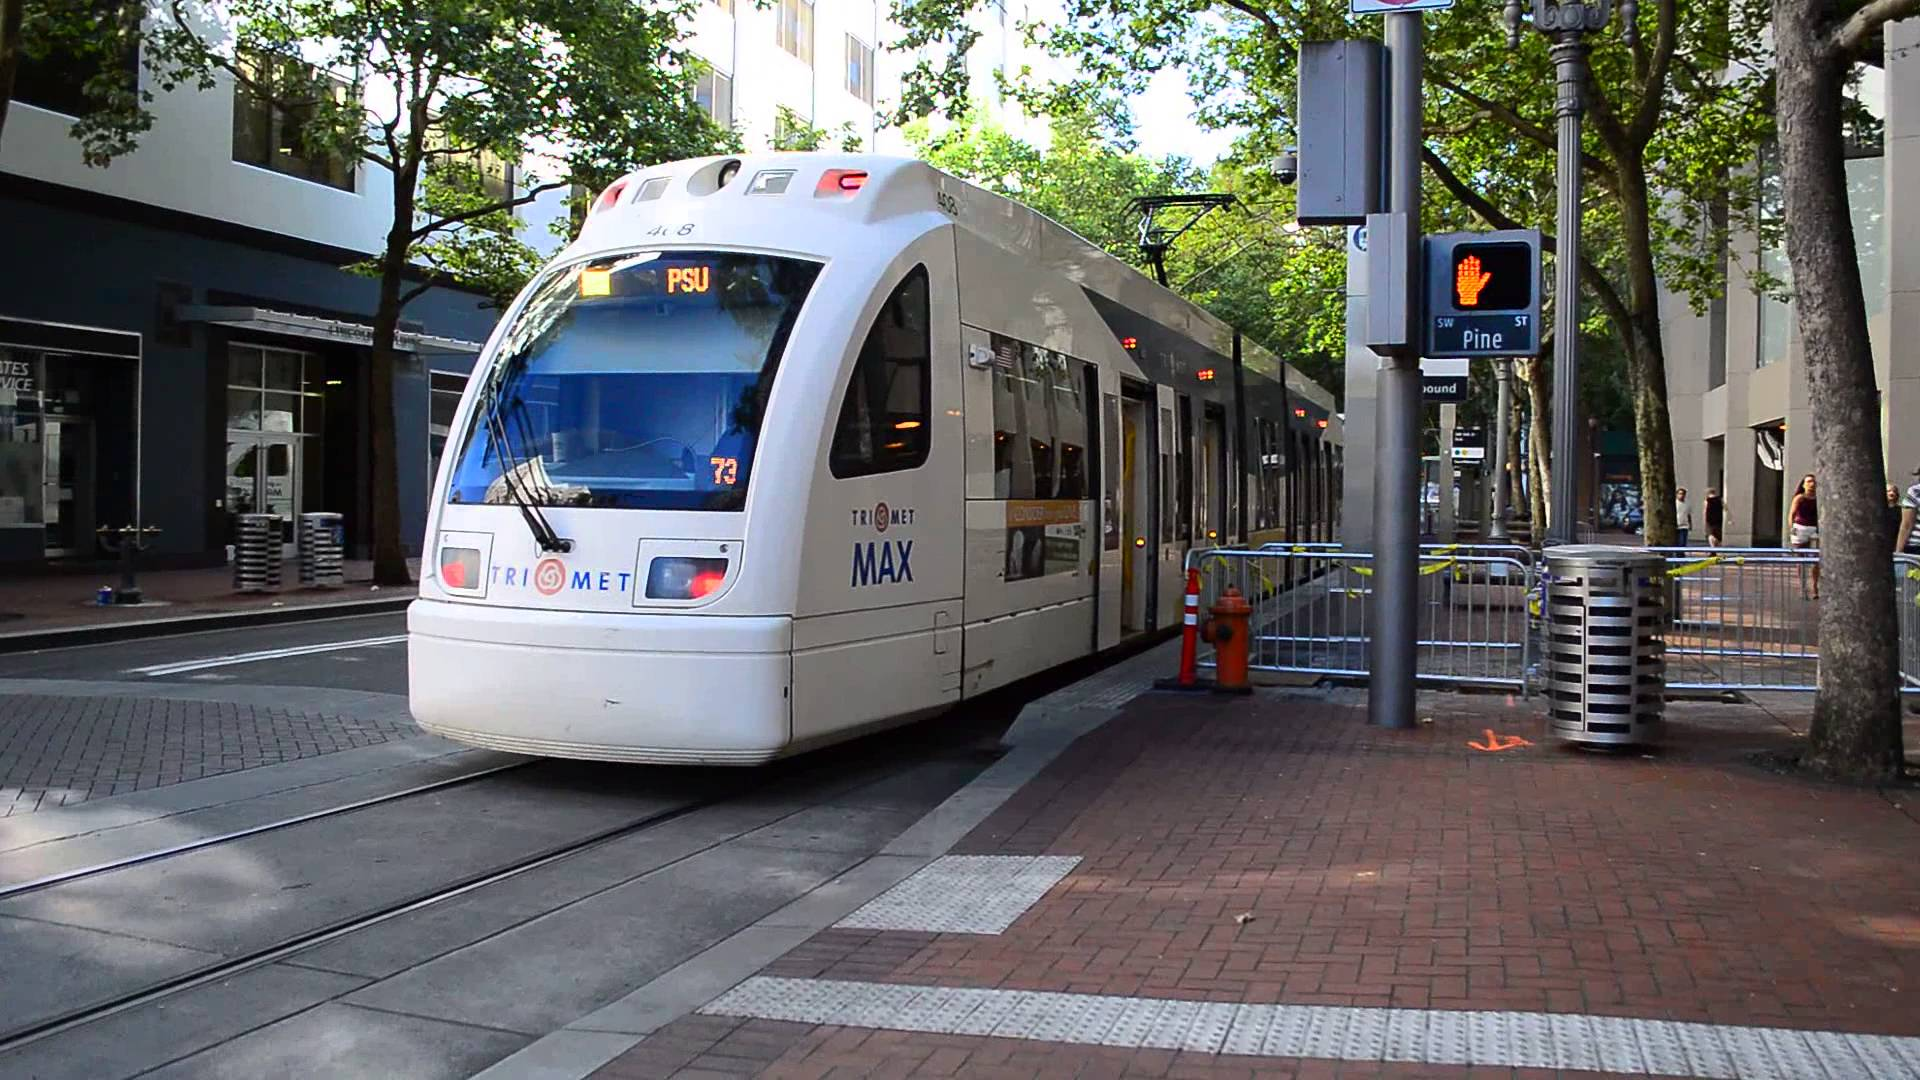

In [2]:
Image("maxresdefault.jpg")

Project: Portland Trimet Data
=================

**By: Pieter Leffers**

Group Participants:

*Rutherford Brakke-Pound*, *Michelle Bird*, *Bruce Irvin*, *Maria Ji*, *Omar Ahmed*, *Justin Wiley*

In [374]:
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

Project Description
-----------------
This is not so much a personal project of mine like many other of my other notebooks on Github; rather this was a group project where I was merely a group facilitator. For this Portland Data Science Group series we were looking at Portland Trimet (Lightrail) data. In addition to lightrail data, we also tried to provide several other datasets that people may be interested in looking at so they could decide which direction they would like to go with their analyses. 

Typically, after the first 30 minutes of the first session of each series the entire group (97 people) has a brainstorming session, where we narrow down the topics down to the number of groups we would like to have. In this case we had 9 people (including myself) volunteering to be group facilitators for each selected topic based on interest. 

The topic my group selected was investigating ***"Correlations with property value or crime rate"***. I believe the initial spirit of the topic put forward was suggesting that crime rates as a result of trimet lightrail activity may have an impact on property value. After a discussion and a more in-depth investigation of the data I suggested the group re-brand single value home property values (Redfin data) to be a proxy for socio-economic status of the area; therefore we may be able to use socio-economic status as a possible controlling factor for lightrail crime activity.

It was also rather apparent that the smallest common analytical unit between the datasets was at the neighborhood level; which was the analytical unit of choice for the 911 trimet related call data available to us. After having found the team I was facilitating to be having trouble cleaning, merging the data, and finishing results, after the sessions were complete I took it upon myself to *'put my money where my mouth is'* and attempt to continue the group's investigation of this topic.

Data Sources:
    --------
Redfin Housing Data
    - 7368 entries of single family home sales from January,2012 to September,2017

911 Call Data
    - Trimet lightrail selected 911 calls from September,2017 to January,2018

Self-googled research on latitude and longitude of Trimet lightrail stops

Trimet Events

Trimet Vehicle



In [3]:
import pandas as pd
import numpy as np
import re

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

Redfin Housing Data
-----------------

In [4]:
url='https://www.redfin.com/blog/data-center'
#webbrowser.open(url)

In [6]:
location='C://Users/pmlef/Documents/Python_work/Python_for_Data_Analysis/Housing/'
housing=pd.read_csv(location+'housing.csv',delimiter=',')
housing.head(n=1)

,Avg Sale To List,Avg Sale To List Mom,Avg Sale To List Yoy,Homes Sold,Homes Sold Mom,Homes Sold Yoy,Inventory,Inventory Mom,Inventory Yoy,Median Dom,...,Median Dom Yoy,Median Sale Price,Median Sale Price Mom,Median Sale Price Yoy,New Listings,New Listings Mom,New Listings Yoy,Period End,Property Type,Region
0,0.985435,-0.50%,-0.10%,8,14.30%,14.30%,9.0,50.00%,28.60%,44.5,...,20.0,$398K,-7.60%,-33.20%,11,10.00%,-15.40%,4/30/2018,All Residential,"Portland, OR - Sullivan's Gulch"


In [9]:
housing.columns

Index(['Avg Sale To List', 'Avg Sale To List Mom', 'Avg Sale To List Yoy',
       'Homes Sold', 'Homes Sold Mom', 'Homes Sold Yoy', 'Inventory',
       'Inventory Mom', 'Inventory Yoy', 'Median Dom', 'Median Dom Mom',
       'Median Dom Yoy', 'Median Sale Price', 'Median Sale Price Mom',
       'Median Sale Price Yoy', 'New Listings', 'New Listings Mom',
       'New Listings Yoy', 'Period End', 'Property Type', 'Region'],
      dtype='object')

In [10]:
housing.sort_values(by='Period End',ascending=False).head(n=1)

,Avg Sale To List,Avg Sale To List Mom,Avg Sale To List Yoy,Homes Sold,Homes Sold Mom,Homes Sold Yoy,Inventory,Inventory Mom,Inventory Yoy,Median Dom,...,Median Dom Yoy,Median Sale Price,Median Sale Price Mom,Median Sale Price Yoy,New Listings,New Listings Mom,New Listings Yoy,Period End,Property Type,Region
3108,0.996688,0.70%,0.00%,62,-1.60%,-11.40%,45.0,-8.20%,-16.70%,25.0,...,10.0,$387K,-1.90%,6.80%,57,-14.90%,-23.00%,9/30/2017,All Residential,"Portland, OR - Pleasant Valley"


In [11]:
print('The starting date for housing prices in the dataset is',housing['Period End'].min())
print('The ending date for housing prices in the dataset is',housing['Period End'].max()) #The time elements appear to not correspond to mproper in and max values

The starting date for housing prices in the dataset is 1/31/2012
The ending date for housing prices in the dataset is 9/30/2017


Here we can see that the 'Region' data doesn't have particularly well matching neighborhood and suburb values

In [7]:
housing['Region'].unique()
houseHoods=housing['Region'].unique().copy()
houseHoods[:15]

array(["Portland, OR - Sullivan's Gulch",
       'Portland, OR - Lents-Powellhurst-Gilbert',
       'Portland, OR - South Tabor', 'Portland, OR - Parkrose',
       'Portland, OR - Eliot', 'Portland, OR - Kerns',
       'Portland, OR - Argay', 'Portland, OR - Multnomah Village',
       'Portland, OR - Lents', 'Portland, OR - North Tabor',
       'Portland, OR - Hillside', 'Portland, OR - Cully',
       'Portland, OR metro area', 'Portland, OR - Brentwood',
       'Portland, OR - Downtown Portland'], dtype=object)

In [8]:
def scrubadub(variable):
    myList=(list(variable))
    clean=[]
    for i in range(0,len(myList)):
        #Regular expressions for removing web addresses
        url_reg  = r'[a-z]*[:.]+\S+|Portland|OR'
        #and replacing with nothing
        url_text=re.sub(url_reg, '', myList[i])
        sep = " "
        junk = re.findall(r"(?i)\b[a-z]+\b", url_text)
        #join the seperated words
        junk = sep.join(junk)
        #remove _s_ spaces from text after punctuation removal
        S_space = re.sub(r' s ','',junk)
        clean.append(S_space)
    return clean

Matching Regions / Neighborhoods

In [9]:
Hood=scrubadub(housing['Region'])
housing['Hood']=Hood
housing[['Region','Hood']].head(n=15)

,Region,Hood
0,"Portland, OR - Sullivan's Gulch",SullivanGulch
1,"Portland, OR - Lents-Powellhurst-Gilbert",Lents Powellhurst Gilbert
2,"Portland, OR - South Tabor",South Tabor
3,"Portland, OR - Parkrose",Parkrose
4,"Portland, OR - Eliot",Eliot
5,"Portland, OR - Kerns",Kerns
6,"Portland, OR - Argay",Argay
7,"Portland, OR - Multnomah Village",Multnomah Village
8,"Portland, OR - Lents",Lents
9,"Portland, OR - North Tabor",North Tabor


Text(0,0.5,'Median Cost of Houses by Neighborhood')

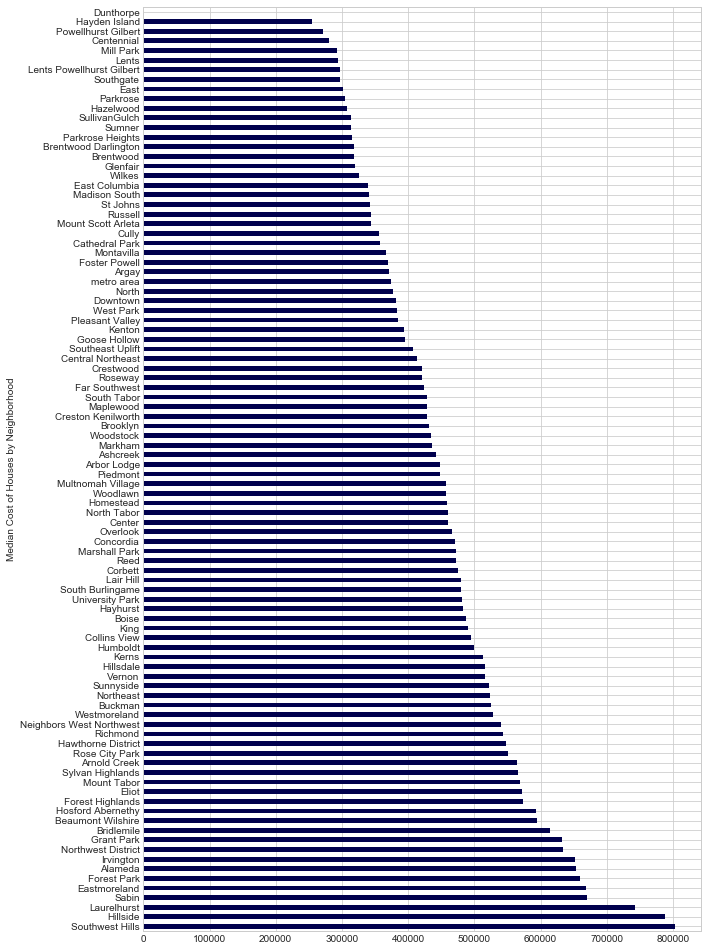

In [10]:
houseReduce=housing[['Period End','Region','Hood','Median Sale Price']].copy() #create a new dataframe
houseReduce.rename(index=str,columns={"Period End": "PeriodEnd"},inplace=True) #rename column for ease
houseReduce.rename(index=str,columns={"Median Sale Price": "MedSale_Price"},inplace=True) #rename column for ease
houseReduce['MedSale_Price']=houseReduce.MedSale_Price.str.replace('$','').str.replace('K','000') #replace $ and K
houseReduce['MedSale_Price']=pd.to_numeric(houseReduce.MedSale_Price,errors='coerce') # Make the column numeric
houseReduce['PeriodEnd']=pd.to_datetime(houseReduce.PeriodEnd) #Change time element to datetime
houseReduce.sort_values(by='PeriodEnd',ascending=True,inplace=True)
houseReduce=houseReduce[6592:7077].copy() # Get time frame to match 911 Call time period (9/9/2017 - 1/1/2018)
#This only needs to be approximate in order to get a sense of housing values at the time
houseReduce.reset_index(drop=True,inplace=True)# resetting the index
houseReduce['ones']=1
houseReduce_GB=houseReduce.groupby(houseReduce['Hood']).sum()
houseReduce_GB['MedSale_Price']=houseReduce_GB.MedSale_Price/5 #five observations per neighborhood in timescale
#houseReduce_GB.iloc[1:,:1]

houseReduce_GB.iloc[1:,:1].sort_values(by='MedSale_Price',ascending=False).plot(kind='barh',figsize=(10,17),cmap='seismic',legend=False)
plt.ylabel('Median Cost of Houses by Neighborhood')

**Plot Explanation:** Here we can see which neighborhoods have the highest median cost of single family homes.

In [11]:
houseReduce_GB=houseReduce_GB.iloc[1:,:1].reset_index()
houseHoods=houseReduce_GB['Hood'].unique()
houseHoods

array(['Alameda', 'Arbor Lodge', 'Argay', 'Arnold Creek', 'Ashcreek',
       'Beaumont Wilshire', 'Boise', 'Brentwood', 'Brentwood Darlington',
       'Bridlemile', 'Brooklyn', 'Buckman', 'Cathedral Park', 'Centennial',
       'Center', 'Central Northeast', 'Collins View', 'Concordia',
       'Corbett', 'Creston Kenilworth', 'Crestwood', 'Cully', 'Downtown',
       'Dunthorpe', 'East', 'East Columbia', 'Eastmoreland', 'Eliot',
       'Far Southwest', 'Forest Highlands', 'Forest Park', 'Foster Powell',
       'Glenfair', 'Goose Hollow', 'Grant Park', 'Hawthorne District',
       'Hayden Island', 'Hayhurst', 'Hazelwood', 'Hillsdale', 'Hillside',
       'Homestead', 'Hosford Abernethy', 'Humboldt', 'Irvington', 'Kenton',
       'Kerns', 'King', 'Lair Hill', 'Laurelhurst', 'Lents',
       'Lents Powellhurst Gilbert', 'Madison South', 'Maplewood',
       'Markham', 'Marshall Park', 'Mill Park', 'Montavilla',
       'Mount Scott Arleta', 'Mount Tabor', 'Multnomah Village',
       'Neighbors 

911 Calls
-------------

In [12]:
location='C://Users/pmlef/Documents/Python_work/Python_for_Data_Analysis/Trimet/'
trimCalls=pd.read_csv(location+'trimet-calls.csv',delimiter=',')
trimCalls.head()

,Unnamed: 0,Call Number,Call Category,Call Group,Neighborhood,Report Date,Response Time (sec),Time In Queue (sec),Travel Time (sec)
0,0,2296401412,TriMet,Disorder,Hosford-Abernethy,7/4/2017 8:33:30 PM,42.0,42.0,0.0
1,1,2392175033,TriMet,Disorder,Hosford-Abernethy,12/18/2017 7:13:27 PM,692.0,49.0,643.0
2,2,2570595016,TriMet,Disorder,Hosford-Abernethy,4/8/2018 10:25:38 AM,2193.0,1156.0,1037.0
3,3,2188786224,TriMet,Disorder,Powellhurst-Gilbert,9/2/2017 8:55:42 AM,1140.0,1003.0,137.0
4,4,2309187422,TriMet,Disorder,Foster-Powell,8/5/2017 12:03:42 PM,797.0,90.0,707.0


In [13]:
trimCalls.sort_values(by='Report Date',ascending=False,inplace=True)

In [14]:
trimCalls.head(n=3)

,Unnamed: 0,Call Number,Call Category,Call Group,Neighborhood,Report Date,Response Time (sec),Time In Queue (sec),Travel Time (sec)
3742,3742,2205590944,TriMet,Disorder,Lloyd,9/9/2017 7:17:03 PM,462.0,54.0,408.0
3815,3815,2205507216,TriMet,Disorder,Sullivan's Gulch,9/9/2017 6:39:11 PM,1150.0,811.0,339.0
122,122,2319828442,TriMet,Disorder,Downtown,9/9/2017 2:19:42 PM,212.0,25.0,187.0


In [15]:
trimCalls.tail(n=3)

,Unnamed: 0,Call Number,Call Category,Call Group,Neighborhood,Report Date,Response Time (sec),Time In Queue (sec),Travel Time (sec)
1428,1428,2415974432,TriMet,Disorder,NaN,1/1/2018 11:01:41 AM,610.0,131.0,479.0
2576,2576,2416892064,TriMet,Disorder,Kenton,1/1/2018 10:36:30 PM,240.0,77.0,163.0
2382,2382,2415649842,TriMet,Disorder,Powellhurst-Gilbert,1/1/2018 10:24:42 AM,257.0,50.0,207.0


In [16]:
print('The first observation of the dataset started on date',trimCalls['Report Date'].max())
print('The last observation of the dataset ended on date',trimCalls['Report Date'].min())

The first observation of the dataset started on date 9/9/2017 7:17:03 PM
The last observation of the dataset ended on date 1/1/2018 10:24:42 AM


Text(0,0.5,'Counts of 911 Calls per Neighborhood')

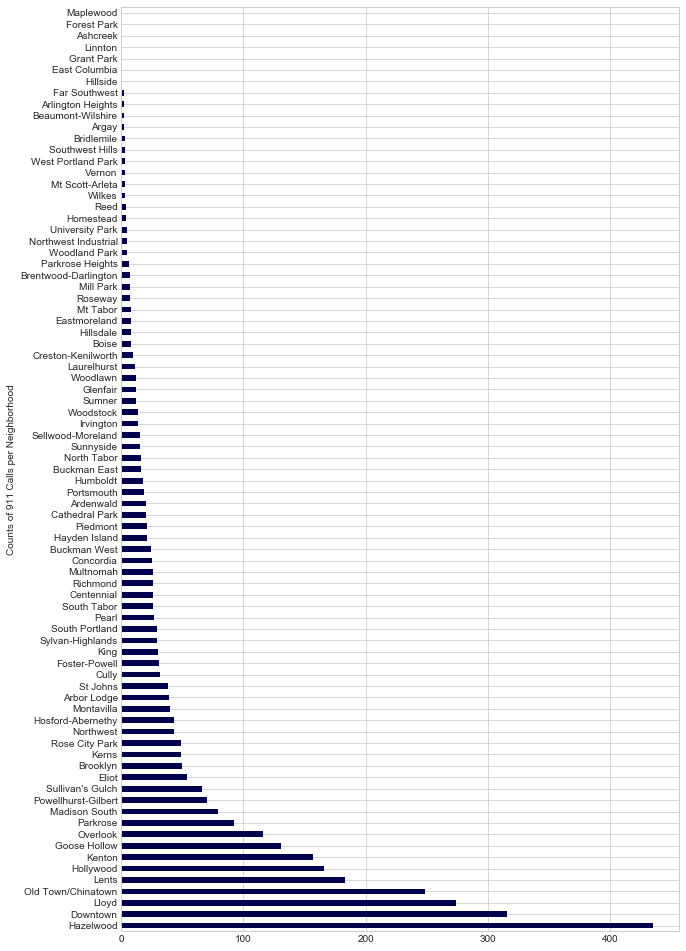

In [17]:
subcatCounts=pd.Series(trimCalls.Neighborhood).value_counts()
subcatCounts.plot(kind='barh',figsize=(10,17),cmap='seismic',legend=False)
plt.ylabel('Counts of 911 Calls per Neighborhood')

**Plot Explanation:** We can see that the neighborhoods / areas with the highest concentration of trimet related 911 calls were Lents, Downtown, Old Town/Chinatown and Hazelwood.

In [18]:
SubCalls=pd.DataFrame(subcatCounts)
SubCalls.reset_index(inplace=True)
SubCalls.columns=(['Hood','CallCount'])
SubCalls.head()

,Hood,CallCount
0,Hazelwood,435
1,Downtown,316
2,Lloyd,274
3,Old Town/Chinatown,249
4,Lents,183


In [19]:
callHoods=trimCalls['Neighborhood'].unique().copy()
callHoods=pd.DataFrame(callHoods,columns=['CallHoods'])
callHoods.fillna('missing',inplace=True) #replace Missings
callHoods[:10]

,CallHoods
0,Lloyd
1,Sullivan's Gulch
2,Downtown
3,Ardenwald
4,Cully
5,Humboldt
6,Overlook
7,Old Town/Chinatown
8,Hazelwood
9,Hosford-Abernethy


In [20]:
len(callHoods)

82

In [21]:
houseHoods=pd.DataFrame(houseHoods,columns=['HouseHoods'])
houseHoods.fillna('missing',inplace=True)
houseHoods[:10]

,HouseHoods
0,Alameda
1,Arbor Lodge
2,Argay
3,Arnold Creek
4,Ashcreek
5,Beaumont Wilshire
6,Boise
7,Brentwood
8,Brentwood Darlington
9,Bridlemile


In [22]:
len(houseHoods)

96

*Here we can get a quick view of the neighborhood differences between Redfin data and 911 call data*

In [23]:
houseHoodsSET=set(houseHoods.HouseHoods)#Creating SETs will automatically make unique units
SubCallsSET=set(SubCalls.Hood)

In [24]:
SubCallsSET.difference(houseHoodsSET) #Executing DIFFERENCE returns the differenes between two SETs

{'Ardenwald',
 'Arlington Heights',
 'Beaumont-Wilshire',
 'Brentwood-Darlington',
 'Buckman East',
 'Buckman West',
 'Creston-Kenilworth',
 'Foster-Powell',
 'Hollywood',
 'Hosford-Abernethy',
 'Linnton',
 'Lloyd',
 'Mt Scott-Arleta',
 'Mt Tabor',
 'Multnomah',
 'Northwest',
 'Northwest Industrial',
 'Old Town/Chinatown',
 'Pearl',
 'Portsmouth',
 'Powellhurst-Gilbert',
 'Sellwood-Moreland',
 'South Portland',
 "Sullivan's Gulch",
 'Sylvan-Highlands',
 'West Portland Park',
 'Woodland Park'}

In [25]:
#Handy piece of code! 
def concatenate_list_data(list): 
    '''
    Concatenates all strings/objects in the list. 
    This is especially nice when paired with regular expressions.
    '''
    result= ''
    for element in list:
        result += str(element)
    return result

Matches Housing Neighborhoods to 911 dataset

In [26]:
SubCalls.head()

,Hood,CallCount
0,Hazelwood,435
1,Downtown,316
2,Lloyd,274
3,Old Town/Chinatown,249
4,Lents,183


Create expressions to use for matching

In [27]:
matchExpr=[]
for i in range(0,len(houseHoods.HouseHoods)):
    matchExpr.append(str(houseHoods.HouseHoods[i][:6])+'.*|')#take the first 6 characters of the strings, 
    #                                                with all luck 6 characters are enough to make them unique
matchExpr=concatenate_list_data(matchExpr)
print('List of regular expressions using first 6 characters of neighborhoods: \n'+matchExpr[:80]+'...etc.')

List of regular expressions using first 6 characters of neighborhoods: 
Alamed.*|Arbor .*|Argay.*|Arnold.*|Ashcre.*|Beaumo.*|Boise.*|Brentw.*|Brentw.*|B...etc.


Identify matches

In [28]:
# For loop to check if any of the neighborhoods match the list of regular expressions created
matchList=[]
for i in range(0,len(SubCalls.Hood)):
    identify=re.findall(r'('+matchExpr+')',SubCalls.Hood[i])
    if identify[0]==SubCalls.Hood[i]:
        matchList.append('1')
    else:
        matchList.append('0')

Showing Neighborhoods that don't match. These results mostly corraborate the results previously showing the differences between the two datasets. The benefit here is we used regular expressions to identify more matches and can manipulate the data a little easier in this format.

In [29]:
SubCalls['CallMatches']=matchList
SubCalls.sort_values(by='Hood',inplace=True)
SubCalls[SubCalls['CallMatches']!='1']

,Hood,CallCount,CallMatches
37,Ardenwald,20,0
72,Arlington Heights,2,0
5,Hollywood,166,0
77,Linnton,1,0
2,Lloyd,274,0
65,Mt Scott-Arleta,3,0
54,Mt Tabor,8,0
3,Old Town/Chinatown,249,0
27,Pearl,27,0
38,Portsmouth,19,0


In [30]:
SubCalls.CallMatches.value_counts()

1    70
0    11
Name: CallMatches, dtype: int64

In [31]:
#Data Cleaning for best matching, a few more can be modified to increase the number of matches

houseReduce_GB.replace('SullivanGulch',"Sullivan's Gulch",inplace=True)
houseReduce_GB.replace('Beaumont Wilshire','Beaumont-Wilshire',inplace=True)
houseReduce_GB.replace('Mount Scott Arleta','Mt Scott-Arleta',inplace=True)
houseReduce_GB.replace('Mount Tabor','Mt Tabor',inplace=True)
houseReduce_GB.replace('Westmoreland','Sellwood-Moreland',inplace=True)
#Merge datasets
DataReduce=houseReduce_GB.merge(SubCalls,how='left',on='Hood')

In [32]:
DataReduce[DataReduce['CallCount']>0].sort_values(by='CallCount').tail(n=20)

,Hood,MedSale_Price,CallCount,CallMatches
13,Centennial,280600.0,26.0,1
79,South Tabor,428000.0,26.0,1
47,King,491000.0,30.0,1
21,Cully,355200.0,32.0,1
83,St Johns,341600.0,38.0,1
1,Arbor Lodge,447400.0,39.0,1
57,Montavilla,366000.0,40.0,1
74,Rose City Park,550600.0,49.0,1
46,Kerns,512800.0,49.0,1
10,Brooklyn,431000.0,50.0,1


In [33]:
#DataReduce=DataReduce[DataReduce['CallCount']>0]
DataReduce=DataReduce[['Hood','MedSale_Price','CallCount']]
#DataReduce.set_index('Hood',inplace=True)

In [34]:
DataReduce.head()

,Hood,MedSale_Price,CallCount
0,Alameda,653200.0,NaN
1,Arbor Lodge,447400.0,39.0
2,Argay,370800.0,2.0
3,Arnold Creek,564400.0,NaN
4,Ashcreek,441400.0,1.0


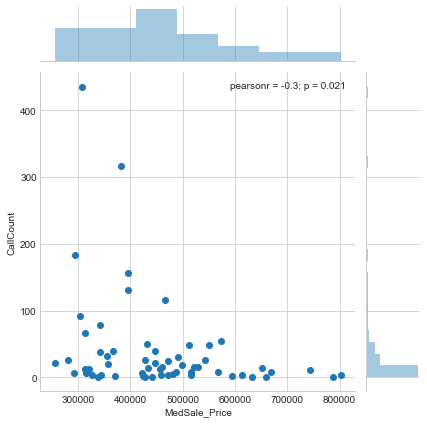

In [35]:
sns.jointplot(DataReduce['MedSale_Price'],DataReduce['CallCount'])

**Plot Explanation:** Judging by the data there doesn't appear to be a correlation between medial sale price for single family homes and trimet related 911 calls.

*Example:*

In [45]:
from geopy.geocoders import Nominatim
import socket
socket.getaddrinfo('127.0.0.1', 8080)
geolocator = Nominatim()

In [46]:
latitude=Blue['Latitude'][11]
longitude=Blue['Longitude'][11]
locString=(latitude,longitude)
location=geolocator.reverse(locString, timeout=10)
print(location.raw['address'])

{'footway': 'Gateway Transit Center', 'neighbourhood': 'Gateway', 'suburb': 'Hazelwood', 'city': 'Portland', 'county': 'Multnomah County', 'state': 'Oregon', 'postcode': '97220', 'country': 'United States of America', 'country_code': 'us'}


In [47]:
def geoLocate(dataframe):
    '''
    This piece of code will take a dataframe with latitude and longitude columns ...
    ...and return the dataframe with address information.
    '''   
    
    import time
    postal=[]
    county=[]
    house_number=[]
    road=[]
    city=[]
    suburb=[]
    neighborhood=[]
    station=[]
    stop=[]

    for i in range(0,len(dataframe)):

        #condition if the cell is empty
        #print(i)
        latitude=dataframe['Latitude'][i]
        longitude=dataframe['Longitude'][i]
        locString=(latitude,longitude)
        location=geolocator.reverse(locString, timeout=10)
        keys=location.raw['address'].keys()

        time.sleep(1)
        #print(location.raw['address'])
            #neighbourhood
        if 'neighbourhood' in keys:
            neighborhood.append(location.raw['address']['neighbourhood'])
        else:        
            neighborhood.append('None')
        #suburb    
        if 'suburb' in keys:
            suburb.append(location.raw['address']['suburb'])
        else:        
            suburb.append('None')  
        #Postal    
        if 'postcode' in keys:
            postal.append(location.raw['address']['postcode'])
        else:        
            postal.append('None')         
        #county    
        if 'county' in keys:
            county.append(location.raw['address']['county'])
        else:        
            county.append('None')    
        #house_number    
        if 'house_number' in keys:
            house_number.append(location.raw['address']['house_number'])
        else:        
            house_number.append('None')    
        #road    
        if 'road' in keys:
            road.append(location.raw['address']['road'])
        else:        
            road.append('None')  
        #city    
        if 'city' in keys:
            city.append(location.raw['address']['city'])
        else:        
            city.append('None')  
        #station    
        if 'bus_station' in keys:
            station.append(location.raw['address']['bus_station'])
        else:        
            station.append('None') 
        #stop    
        if 'bus_stop' in keys:
            stop.append(location.raw['address']['bus_stop'])
        else:        
            stop.append('None')  


    dataframe['house_number']=house_number
    dataframe['road']=road
    dataframe['postal']=postal
    dataframe['city']=city
    dataframe['county']=county
    dataframe['hood']=neighborhood
    dataframe['burb']=suburb
    dataframe['station']=station
    dataframe['stop']=stop

    return dataframe

In [48]:
url='https://trimet.org/schedules/w/t1090_0.htm'
#webbrowser.open(url)

In [49]:
location='C://Users/pmlef/Documents/Python_work/Python_for_Data_Analysis/Trimet/'
Red=pd.read_csv(location+'Red.csv',delimiter=',')
Red=Red.T
Red.reset_index(inplace=True)
#Red=Red.iloc[:,:2]
Red.columns=['Stops', 'StopID','Latitude','Longitude']
Red['Stops']=Red.Stops.str.replace('TC MAX Station','')
Red['Stops']=Red.Stops.str.replace('MAX Station','')
Red['StopID']=Red.StopID.str.replace('Stop ID','')
Red['Line']='Red'
Red

,Stops,StopID,Latitude,Longitude,Line
0,Beaverton,9821,45.49139,-122.801704,Red
1,Sunset,9969,45.510323,-122.78137,Red
2,Washington Park,10120,45.510694,-122.717424,Red
3,Providence Park,9758,45.521603,-122.689806,Red
4,Pioneer Square South,8334,45.518504,-122.679146,Red
5,Rose Quarter,8340,45.530260,-122.665532,Red
6,Hollywood/NE 42nd Ave,8344,45.533083,-122.621067,Red
7,Gateway/NE 99th Ave,8347,45.530667,-122.563545,Red
8,Portland Int'l Airport,10579,45.587752,-122.593062,Red


In [ ]:
#Get address info from Latitude and Longitude
Red=geoLocate(Red)

In [ ]:
url='https://trimet.org/schedules/w/t1090_0.htm'
#webbrowser.open(url)

In [ ]:
location='C://Users/pmlef/Documents/Python_work/Python_for_Data_Analysis/Trimet/'
Blue=pd.read_csv(location+'Blue.csv',delimiter=',')
Blue=Blue.T
Blue.reset_index(inplace=True)
Blue=Blue.iloc[:,:5]
Blue.columns=['Stops', 'StopID','Address','Latitude','Longitude']
Blue=Blue[['Stops', 'StopID','Latitude','Longitude']]
Blue['Stops']=Blue.Stops.str.replace('TC MAX Station','')
Blue['Stops']=Blue.Stops.str.replace('MAX Station','')
Blue['StopID']=Blue.StopID.str.replace('Stop ID','')
Blue['Line']='Blue'
Blue

In [ ]:
Blue=geoLocate(Blue)

In [ ]:
url='https://trimet.org/schedules/w/t1200_0.htm'
#webbrowser.open(url)

In [ ]:
location='C://Users/pmlef/Documents/Python_work/Python_for_Data_Analysis/Trimet/'
Green=pd.read_csv(location+'Green.csv',delimiter=',')
Green=Green.T
Green.reset_index(inplace=True)
Green.columns=['Stops', 'StopID','Address','junk','Latitude','Longitude']
Green=Green[['Stops','StopID','Latitude','Longitude']]
Green['Stops']=Green.Stops.str.replace('TC MAX Station','')
Green['Stops']=Green.Stops.str.replace('MAX Station','')
Green['StopID']=Green.StopID.str.replace('Stop ID','')
Green['Line']='Green'
Green

In [ ]:
Green=geoLocate(Green)

In [ ]:
url='https://trimet.org/schedules/w/t1190_1.htm'
#webbrowser.open(url)

In [ ]:
location='C://Users/pmlef/Documents/Python_work/Python_for_Data_Analysis/Trimet/'
Yellow=pd.read_csv(location+'Yellow.csv',delimiter=',')
Yellow=Yellow.T
Yellow.reset_index(inplace=True)
#Yellow=Yellow.iloc[:,:2]
Yellow.columns=['Stops', 'StopID','Latitude','Longitude']
Yellow['Stops']=Yellow.Stops.str.replace('TC MAX Station','')
Yellow['Stops']=Yellow.Stops.str.replace('MAX Station','')
Yellow['StopID']=Yellow.StopID.str.replace('Stop ID','')
Yellow['Line']='Yellow'
Yellow

In [ ]:
Yellow=geoLocate(Yellow)

In [ ]:
url='https://trimet.org/schedules/w/t1290_0.htm'
#webbrowser.open(url)

In [ ]:
location='C://Users/pmlef/Documents/Python_work/Python_for_Data_Analysis/Trimet/'
Orange=pd.read_csv(location+'Orange.csv',delimiter=',')
Orange=Orange.T
Orange.reset_index(inplace=True)
#Orange=Orange.iloc[:,:2]
Orange.columns=['Stops', 'StopID','Latitude','Longitude']
Orange['Stops']=Orange.Stops.str.replace('TC MAX Station','')
Orange['Stops']=Orange.Stops.str.replace('MAX Station','')
Orange['StopID']=Orange.StopID.str.replace('Stop ID','')
Orange['Line']='Orange'
Orange

In [ ]:
Orange=geoLocate(Orange)

In [ ]:
LinesKey=Red.append(Blue).append(Green).append(Yellow).append(Orange)
LinesKey.reset_index(inplace=True,drop=True)
LinesKey['burb'].replace('Portland Downtown','Downtown',inplace=True)
LinesKey['burb'].replace('Hosford-Abernethy','Hosford Abernethy',inplace=True)
LinesKey['burb'].replace('Old Town','Old Town/Chinatown',inplace=True)
LinesKey['burb'].replace('Ardenwald-Johnson Creek','Ardenwald',inplace=True)
LinesKey['burb'].replace('Waverly Heights','Ardenwald',inplace=True)
LinesKey.drop('hood',axis=1,inplace=True)
LinesKey.rename(index=str,columns={"burb": "Hood"},inplace=True) 
LinesKey.head()

In [ ]:
#Save the dataset
LinesKey.to_pickle('LinesKey.pickle')

In [ ]:
LinesKey=pd.read_pickle('LinesKey.pickle')

In [ ]:
LinesReduced=LinesKey[['Line','Hood']]
LinesReduced.head()

In [ ]:
BurbHoodSet=set(LinesKey.Hood)
BurbHoodList=list(BurbHoodSet)
DataReduceSet=set(SubCalls.Hood)
BurbHoodSet.difference(DataReduceSet)

In [ ]:
CallsLines=SubCalls.merge(LinesReduced,how='left',on='Hood')
CallsLines.drop('CallMatches',axis=1,inplace=True)
CallsLines['Line']=CallsLines.Line.fillna('NoLine')
CallsLines=CallsLines.drop_duplicates()
CallsLines.head()

In [ ]:
temp=pd.DataFrame(CallsLines['Line'])
for x in temp.Line.unique():
    temp[x]=(temp.Line==x).astype(int)
CallsLines=pd.concat([CallsLines,temp],axis=1)
CallsLines.drop('Line',axis=1,inplace=True)
PriceCallLine=CallsLines[['Hood','Yellow','Orange','NoLine','Red','Blue','Green']].merge(DataReduce,how='left',on='Hood')
PriceCallLine=PriceCallLine[PriceCallLine['NoLine']<1][['Hood','MedSale_Price']]
PriceCallLine=PriceCallLine.drop_duplicates()

In [ ]:
LineHoodDF=CallsLines[CallsLines['NoLine']<1].groupby('Hood').sum()
LineHoodDF.reset_index(inplace=True)
LineHoodDF['CountLines']=LineHoodDF.loc[:,'Yellow':'Green'].sum(axis=1)
LineHoodDF['CallPerLine']=LineHoodDF['CallCount']/LineHoodDF['CountLines']
LineHoodDF=LineHoodDF.merge(PriceCallLine,how='left',on='Hood')

In [ ]:
RowTotal=['Total',LineHoodDF.CallCount.sum(), \
                     LineHoodDF['CallCount'][LineHoodDF['Yellow']==1].sum(),\
                     LineHoodDF['CallCount'][LineHoodDF['Orange']==1].sum(),\
                     LineHoodDF.NoLine.sum(),
                     LineHoodDF['CallCount'][LineHoodDF['Red']==1].sum(),\
                     LineHoodDF['CallCount'][LineHoodDF['Blue']==1].sum(),\
                     LineHoodDF['CallCount'][LineHoodDF['Green']==1].sum(),\
                     LineHoodDF.CountLines.max(),LineHoodDF.CallPerLine.sum(),LineHoodDF.MedSale_Price.sum()]

#LineHoodDF.loc[len(LineHoodDF)]

In [ ]:
RowAverage=['PerStop',\
            int(4990/13), \
            int(2639/5),\
            int(2426/5),\
            int(3649/5),\
            int(3649/5),\
            int(4313/5),\
            5,\
            int(1893.0/13),\
            int(3117200/8)]

In [ ]:
LineHoodDF.loc[len(LineHoodDF)]=RowTotal
LineHoodDF.drop('NoLine',inplace=True,axis=1)
LineHoodDF.loc[len(LineHoodDF)]=RowAverage

**Frequency Table**

In [ ]:
LineHoodDF

In [ ]:
LineHoodDF[LineHoodDF['Yellow']==1]['MedSale_Price']

In [ ]:
plotDF=LineHoodDF.iloc[14:,2:7].T
plotDF.rename(index=str,columns={14:'PerStop'},inplace=True)
#plotDF.plot(kind='bar',figsize=(6,8),cmap='seismic',legend=False)

In [ ]:
plotDF
plotDF.reset_index(inplace=True)
plotDF.rename(index=str,columns={"index": "Lines"},inplace=True)

In [ ]:
import seaborn as sns
sns.set_style("whitegrid")

palette ={"Yellow":"C8","Orange":"C1","Red":"C3", "Blue":"C0", "Green":"C2"}

ax = sns.barplot(x="Lines", y="PerStop", data=plotDF, palette=palette)


In [ ]:
YellowSum=LineHoodDF[LineHoodDF['Yellow']==1]['MedSale_Price'].sum()/LineHoodDF[LineHoodDF['Yellow']==1]['MedSale_Price'].count()
print('The Median Sale price for Yellow Line is:',YellowSum)
OrangeSum=LineHoodDF[LineHoodDF['Orange']==1]['MedSale_Price'].sum()/LineHoodDF[LineHoodDF['Orange']==1]['MedSale_Price'].count()
print('The Median Sale price for Orange Line is:',OrangeSum)
RedSum=LineHoodDF[LineHoodDF['Red']==1]['MedSale_Price'].sum()/LineHoodDF[LineHoodDF['Red']==1]['MedSale_Price'].count()
print('The Median Sale price for Red Line is:',RedSum)
BlueSum=LineHoodDF[LineHoodDF['Blue']==1]['MedSale_Price'].sum()/LineHoodDF[LineHoodDF['Blue']==1]['MedSale_Price'].count()
print('The Median Sale price for Blue Line is:',BlueSum)
GreenSum=LineHoodDF[LineHoodDF['Green']==1]['MedSale_Price'].sum()/LineHoodDF[LineHoodDF['Green']==1]['MedSale_Price'].count()
print('The Median Sale price for Green Line is:',GreenSum)

Conclusion & Plot Explanation
----------

We can see from the time period of (September 9th, 2017 - January 1st, 2018) the green line seems to have had the greatest number of calls of all the lightrail lines. Furthermore, the average median sale price for single family homes for the Green line appears to have lowest sale price of all; perhaps suggesting a possible relationship between low home sale price (Low Socio-Economic Status) and increased number of 911 calls. Additionally, other rail lines would seem to follow this previously mentioned trend further supporting this *suggestion*.

***However***, these implications are merely suggestive at best and not based on any statistical test and may be entirely circumstantial. These results have not taken into account any possible confounding relationships between the factors assessed thus far. In point of fact, many traditional tests are not appropriate for furthur investigation for these questions because of lack of independance between the factors. It is clear to see from the map below that a large number of neighborhoods cross multiple rail lines and therefore we cannot ascertain which particular rail line was given for which particular neighborhood.

In [ ]:
Image("railsystem.png")

Examples and Additional Materials
=============

Trimet Events
---------------

In [487]:
location='C://Users/pmlef/Documents/Python_work/Python_for_Data_Analysis/Trimet/'
trimEventMonth=pd.read_csv(location+'events_month.csv',delimiter=',')
trimEventMonth.head()

,bearing,delay,event_timestamp,lastLocID,lastStopSeq,nextLocID,nextStopSeq,tripID,vehicle_id,vehicle_location_latitude,vehicle_location_longitude
0,306,-430,2017-01-01 08:00:03,9819,24,9827,25,6999629,251,45.502307,-122.836712
1,20,-113,2017-01-01 08:00:04,13720,1,13721,2,7003700,405,45.439829,-122.640634
2,91,-17,2017-01-01 08:00:22,9848,1,9846,2,6998908,306,45.521351,-122.986448
3,358,-56,2017-01-01 08:00:23,9299,6,7763,7,7000472,420,45.526400,-122.676568
4,98,-729,2017-01-01 08:00:23,8357,46,8359,47,6998905,118,45.501997,-122.419650


In [359]:
trimEventMonth.sort_values(by='event_timestamp',ascending=False).head()

,bearing,delay,event_timestamp,lastLocID,lastStopSeq,nextLocID,nextStopSeq,tripID,vehicle_id,vehicle_location_latitude,vehicle_location_longitude
164440,301,15,2017-01-31 23:59:59,8362,5,8363,6,7127635,312,45.516942,-122.462215
164439,306,2,2017-01-31 23:59:59,9819,36,9827,37,7127629,411,45.505379,-122.842342
164438,350,0,2017-01-31 23:59:58,13132,24,13132,1,7129550,314,45.436024,-122.567887
164437,352,-132,2017-01-31 23:59:58,11508,8,11509,9,7128192,417,45.538771,-122.674562
164436,201,-6,2017-01-31 23:59:57,9820,22,10117,23,7126629,116,45.518961,-122.692238


In [360]:
trimEventMonth['event_timestamp'].min()

'2017-01-01 08:00:03'

In [361]:
trimEventMonth['event_timestamp'].max()

'2017-01-31 23:59:59'

Trimet Vehicle
----------------

In [3]:
location='C://Users/pmlef/Documents/Python_work/Python_for_Data_Analysis/Trimet/'
trimVehicle=pd.read_csv(location+'vehicle-data-sample.csv',delimiter=',')
trimVehicle=trimVehicle.iloc[:,1:]
trimVehicle=trimVehicle[trimVehicle['type']=='rail']
trimVehicle.head()

,bearing,blockID,city,delay,device_id,direction,event_timestamp,expires,garage,inCongestion,...,signMessageLong,state,system,tripID,type,vehicle_id,vehicle_location_latitude,vehicle_location_longitude,vehicle_location_latitude.1,vehicle_location_longitude.1
0,147,9066,portland,-31,317,1,1483257600,2017-01-01T08:08:31,RUBY,False,...,MAX Orange Line to Milwaukie,oregon,trimet,7004120.0,rail,317,45.483499,-122.643220,45.483499,-122.643220
3,20,9069,portland,-113,413,0,1483257604,2017-01-01T08:07:53,RUBY,False,...,MAX Orange Line to City Center/Expo Center,oregon,trimet,7003700.0,rail,413,45.439829,-122.640634,45.439829,-122.640634
14,91,9001,portland,-17,110,0,1483257622,2017-01-01T08:06:47,RUBY,False,...,MAX Blue Line to Gresham,oregon,trimet,6998908.0,rail,110,45.521351,-122.986448,45.521351,-122.986448
15,358,9067,portland,-56,420,0,1483257622,2017-01-01T08:10:26,RUBY,False,...,MAX Yellow Line to Expo Center,oregon,trimet,7000472.0,rail,420,45.526400,-122.676568,45.526400,-122.676568
16,358,9067,portland,-56,412,0,1483257622,2017-01-01T08:10:26,RUBY,False,...,MAX Yellow Line to Expo Center,oregon,trimet,7000472.0,rail,412,45.526400,-122.676568,45.526400,-122.676568


Example of GeoCoding from Latitude and Longitude
========================
GeoCoding 
---------

**Example Data**

In [728]:
trimEventMonth[:1]

,bearing,delay,event_timestamp,lastLocID,lastStopSeq,nextLocID,nextStopSeq,tripID,vehicle_id,vehicle_location_latitude,vehicle_location_longitude
0,306,-430,2017-01-01 08:00:03,9819,24,9827,25,6999629,251,45.502307,-122.836712


The latitude and longitude of the 4th row of the dataset

In [729]:
trimEventMonth['vehicle_location_latitude'][3],trimEventMonth['vehicle_location_longitude'][3]

(45.526400000000002, -122.676568)

In [730]:
latitude=trimEventMonth['vehicle_location_latitude'][3]
longitude=trimEventMonth['vehicle_location_longitude'][3]
locString=(latitude,longitude)

In [731]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()
location=geolocator.reverse(locString, timeout=10)
print(location.raw['address'])

{'house_number': '414', 'road': 'Northwest 6th Avenue', 'neighbourhood': 'Chinatown', 'suburb': 'Old Town', 'city': 'Portland', 'county': 'Multnomah County', 'state': 'Oregon', 'postcode': '97209', 'country': 'United States of America', 'country_code': 'us'}


See the keys in the dictionary

In [732]:
location.raw['address'].keys()

dict_keys(['house_number', 'road', 'neighbourhood', 'suburb', 'city', 'county', 'state', 'postcode', 'country', 'country_code'])

Indexing dictionary key (neighbourhood)

In [733]:
location.raw['address']['neighbourhood']

'Chinatown'

Indexing dictionary key (suburb)

In [734]:
location.raw['address']['suburb']

'Old Town'

In [735]:
addyKey=pd.DataFrame(data=trimEventMonth, columns=['vehicle_location_longitude','vehicle_location_latitude'])
addyKey['hood']=None

In [736]:
addyKey.head(n=3)

,vehicle_location_longitude,vehicle_location_latitude,hood
0,-122.836712,45.502307,None
1,-122.640634,45.439829,None
2,-122.986448,45.521351,None


In [737]:
test=addyKey.head().copy()
test.head()
#print(len(test))

,vehicle_location_longitude,vehicle_location_latitude,hood
0,-122.836712,45.502307,None
1,-122.640634,45.439829,None
2,-122.986448,45.521351,None
3,-122.676568,45.526400,None
4,-122.419650,45.501997,None


In [738]:
import time
#Create Lists for Populating
latList=[]
longList=[]
neighborhood=[]
suburb=[]
postal=[]

#modify range    
for i in range(0,len(test)):
    #condition if the cell is empty
    if test['hood'][i]==None:
        print(i)
        latitude=test['vehicle_location_latitude'][i]
        longitude=test['vehicle_location_longitude'][i]
        locString=(latitude,longitude)
        location=geolocator.reverse(locString, timeout=10)
        keys=location.raw['address'].keys()
        
        time.sleep(1)
        #print(location.raw['address'])
            #neighbourhood
        if 'neighbourhood' in keys:
            neighborhood.append(location.raw['address']['neighbourhood'])
        else:        
            neighborhood.append('None')
        #suburb    
        if 'suburb' in keys:
            suburb.append(location.raw['address']['suburb'])
        else:        
            suburb.append('None')  
        #Postal    
        if 'postcode' in keys:
            postal.append(location.raw['address']['postcode'])
        else:        
            postal.append('None')       
    else:
        continue

test['hood']=neighborhood
test['burb']=suburb
test['postal']=postal
test

0
1
2
3
4


,vehicle_location_longitude,vehicle_location_latitude,hood,burb,postal
0,-122.836712,45.502307,None,Huber,97003
1,-122.640634,45.439829,Ardenwald,Waverly Heights,97222
2,-122.986448,45.521351,Glencoe Estates,None,97123-4201
3,-122.676568,45.526400,Chinatown,Old Town,97209
4,-122.419650,45.501997,None,Twelvemile Corner,97030
